# Unmixing on the Feely dataset
See the report for further information

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from InfraRender.InfraRender.dispersion_model_dict import DispersionModelDict
from InfraRender.util import MixedSpectra
from InfraRender.util import get_metrics, save_list_of_dicts, create_result_directory, consolidate_feely, create_experiment_directory
from src.regularization import DispersionRegularization, AbundanceRegularization
from src.objective import SmoothedLinearUnmixing
from src.solver import AutogradDescent

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
torch.autograd.set_detect_anomaly(True)
dtype = torch.float64

# experiment hyperparameters
min_endmemb = 0.05
epochs = 70
lr = 1e-2
betas = (0.9, 0.999)
device = 'cuda'
p = 0.95
p_lambda = 1e-4
rho_tol = 5e-2
gamma_tol = 5e-3
eps_tol = 1e-4
freq_tol = 1e-2
mode_weight_tol = 1e-4

mixtures = MixedSpectra(ascii_spectra="InfraRender/input/test/mtes_kimmurray_rocks_full_tab.txt",
                        meta_csv="InfraRender/input/test/mtes_kimmurray_rocks_full_meta.csv")
spectra = mixtures.spectra[104:, :].T
wavenumbers = mixtures.bands[104:]
abundances = mixtures.abundances
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
wavenumbers = torch.tensor(wavenumbers, dtype=dtype).to(device)

endmemberModels = DispersionModelDict('InfraRender/input/dispersionModelParameters/feely_params.hdf', wavenumbers=wavenumbers, dtype=dtype, device=device)
model = nn.ModuleDict(endmemberModels)

# set constraint tolerances
for name, endmember in model.items():
    endmember.set_constraint_tolerance(freq_tolerance=freq_tol, gamma_tolerance=gamma_tol, epsilon_tolerance=eps_tol,
                                       rho_tolerance=rho_tol, mode_weight_tolerance=mode_weight_tol)

/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:199: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon = torch.from_numpy(paramFile['epsilon'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:203: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_max = torch.from_numpy(paramFile['epsilon_max'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:207: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_min = torch.from_numpy(paramFile['epsilon_min'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:208: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  mode_weight = torc

In [58]:
class EMWrapper(nn.ModuleDict):
    def forward(self):
        endmemberSpectra = torch.empty((1,1,38,830))
        for i, model in enumerate(self.values()):
            endmemberSpectra[0,0,i,:] = model.forward()
        return endmemberSpectra.to(device)

In [59]:
# No spatial regularisation on the physical parameters here (no spatial correlation between the pixels of the Feely dataset)
class NullRegularization(nn.Module):
    def __init__(self):
        super().__init__()
        self.null = torch.tensor(0).to(device)
        
    def forward(self, x):
        return self.null

In [60]:
import scipy as sc
import numpy as np

sc.sparse.random(1,38, density=0.2).A.sum()

3.7968909076607718

## Our approach

Image 0


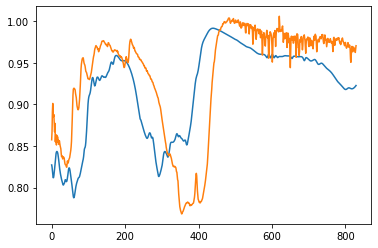

 Epoch 65	 Current loss: 8.5406659916398454

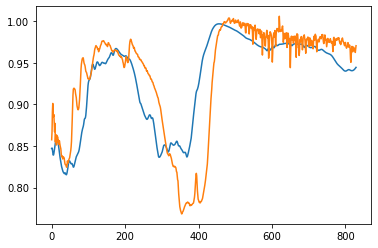

Image 1


/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:199: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon = torch.from_numpy(paramFile['epsilon'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:203: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_max = torch.from_numpy(paramFile['epsilon_max'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:207: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_min = torch.from_numpy(paramFile['epsilon_min'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:208: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  mode_weight = torc

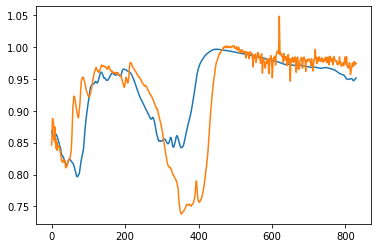

 Epoch 65	 Current loss: 8.7025616953701324

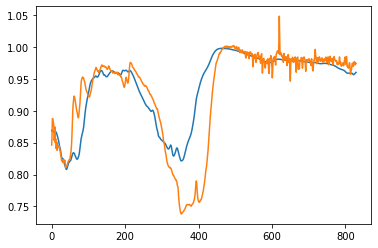

Image 2


/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:199: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon = torch.from_numpy(paramFile['epsilon'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:203: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_max = torch.from_numpy(paramFile['epsilon_max'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:207: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_min = torch.from_numpy(paramFile['epsilon_min'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:208: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  mode_weight = torc

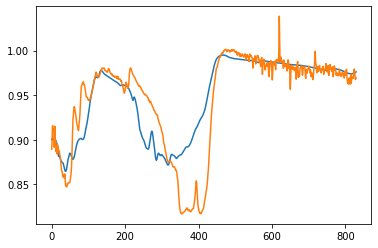

 Epoch 65	 Current loss: 7.2523068129232566

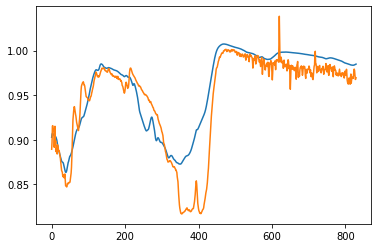

Image 3


/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:199: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon = torch.from_numpy(paramFile['epsilon'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:203: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_max = torch.from_numpy(paramFile['epsilon_max'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:207: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_min = torch.from_numpy(paramFile['epsilon_min'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:208: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  mode_weight = torc

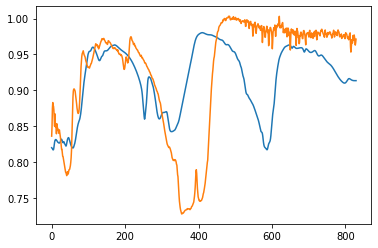

 Epoch 65	 Current loss: 9.8396209240173237

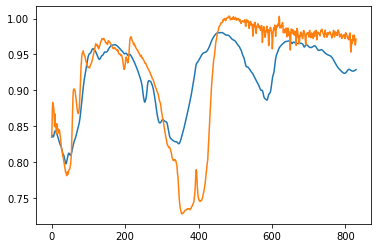

Image 4


/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:199: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon = torch.from_numpy(paramFile['epsilon'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:203: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_max = torch.from_numpy(paramFile['epsilon_max'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:207: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_min = torch.from_numpy(paramFile['epsilon_min'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:208: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  mode_weight = torc

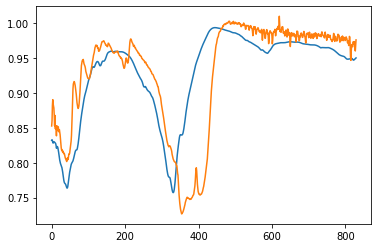

 Epoch 65	 Current loss: 8.9328599698848363

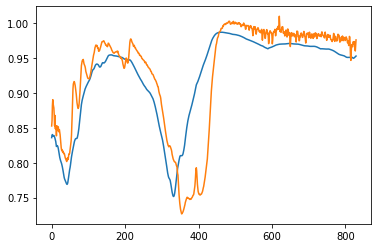

In [61]:
# Holders for the different pixels seen
solvers, trueSpectras, trueAbundances_, init_ab, init_sig = list(), list(), list(), list(), list()
j = 0
for trueSpectra, trueAbundances in zip(spectra, mixtures.abundances):
    if mixtures.category[j] == 'invalid':
        pass
    else:
        print(f"Image {j}")
        trueSpectras.append(trueSpectra)
        trueAbundances_.append(trueAbundances)

        # Create torch tensors
        trueSpectra = torch.tensor(trueSpectra).reshape((1, 1, 830)).type(dtype).to(device)
        trueAbundances = torch.tensor(trueAbundances).reshape((1,1,17)).type(dtype).to(device)
        
        # Initialise randomly, sparsely the abondances
        sparse_ab = sc.sparse.random(1,38, density=0.2).A.reshape((1,1,38))
        sparse_ab /= sparse_ab.sum()
        init_ab.append(sparse_ab)
        
        A = torch.from_numpy(sparse_ab).to(device).type(dtype).requires_grad_()

        # Design the objective function
        endmemberModels = DispersionModelDict('InfraRender/input/dispersionModelParameters/feely_params.hdf', wavenumbers=wavenumbers, dtype=dtype, device=device)
        model = EMWrapper(endmemberModels).to(device)
        regu_A = AbundanceRegularization(sparsity_penalty=0.1, barrier_penalty=1).to(device)
        regu_theta = NullRegularization().to(device)
        objective = SmoothedLinearUnmixing(trueSpectra, model, A, regu_A, regu_theta).to(device)
        solvers.append(AutogradDescent(objective).to(device))
        
        optimization = solvers[-1]
        
        sign = np.zeros((38, 830))
        for i, mod in enumerate(model.values()):
            sign[i, :] = mod.forward().cpu().detach().numpy()
        init_sig.append(sign)

        # Print true spectrum VS reconstructed spectrum at initialisation
        plt.plot(objective.reconstruct()[0,0].cpu().detach().numpy())
        plt.plot(trueSpectra[0,0].cpu().detach().numpy())
        plt.show()

        for name, endmember in model.items():
            endmember.set_constraint_tolerance(freq_tolerance=freq_tol,
                                               gamma_tolerance=gamma_tol,
                                               epsilon_tolerance=eps_tol,
                                               rho_tolerance=rho_tol,
                                               mode_weight_tolerance=mode_weight_tol)
        optimization.fit(trueSpectra, epochs=epochs, learning_rate=lr, betas=betas)

        # Print true spectrum VS reconstructed spectrum after fitting
        plt.plot(objective.reconstruct()[0,0].cpu().detach().numpy())
        plt.plot(trueSpectra[0,0].cpu())
        plt.show()
        j += 1
        
        if j == 5:  # for computation reasons, limit to 5 images
            break

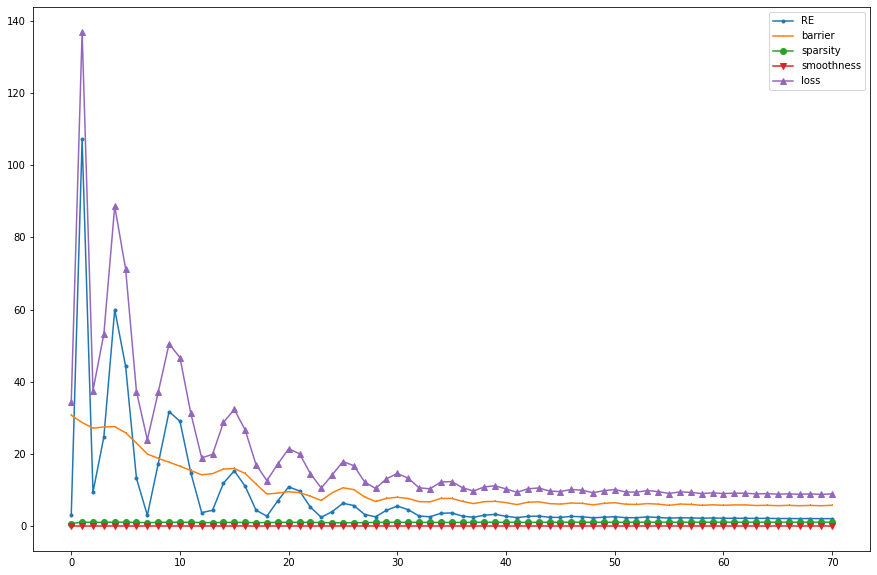

In [62]:
from matplotlib import markers


valid_markers = ([item[0] for item in markers.MarkerStyle.markers.items() if
item[1] is not 'nothing' and not item[1].startswith('tick') and not item[1].startswith('caret')])

# Visualise some training measures for the first 100 steps
solv = solvers[-1]
plt.figure(figsize=(15,10))
for i, (key, value) in enumerate(solv.memory.items()):
    plt.plot(value[:], label=key, marker=valid_markers[i])
plt.legend()
plt.show()

## Comparison with the Analysis-by-Synthesis baseline

In [63]:
from InfraRender.InfraRender import AnalysisBySynthesis

jani = list()
epochs = 1
j = 0
for trueSpectra, trueAbundances in zip(spectra, mixtures.abundances):
    if mixtures.category[j] == 'invalid':
        pass
    else:
        trueSpectra = torch.from_numpy(trueSpectra).type(dtype).to(device)
        trueAbundances = torch.from_numpy(trueAbundances).type(dtype).to(device)
        model = AnalysisBySynthesis(paramFile='InfraRender/input/dispersionModelParameters/feely_params.hdf', p=p, lam=p_lambda,
                            wavenumbers=wavenumbers, dtype=dtype, device=device)
        for name, endmember in model.endmemberModels.items():
            endmember.set_constraint_tolerance(freq_tolerance=freq_tol,
                                               gamma_tolerance=gamma_tol,
                                               epsilon_tolerance=eps_tol,
                                               rho_tolerance=rho_tol,
                                               mode_weight_tolerance=mode_weight_tol)
        model.fit(trueSpectra, epochs=epochs, learningRate=lr, betas=betas)
        modelAbundances = consolidate_feely(model.abundances)
        jani.append(model)
        j += 1
        
        if j == 5:  # same as previously
            break

/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:199: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon = torch.from_numpy(paramFile['epsilon'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:203: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_max = torch.from_numpy(paramFile['epsilon_max'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:207: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  epsilon_min = torch.from_numpy(paramFile['epsilon_min'].value).type(dtype).to(device)
/home/javisty/Work/rproj/spectral_unmixing/InfraRender/InfraRender/single_axis_vibration.py:208: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  mode_weight = torc

In [64]:
a0 = np.zeros((5, 38))  # init abundance map
m0 = np.zeros((5, 38, 830))  # init signatures
j_sig = np.zeros((5, 38, 830))  # fitted signatures
j_ab = np.zeros((5, 38))  # fitted abundances
p_sig = np.zeros((5, 38, 830))  # our fitted signatures
p_ab = np.zeros((5, 38))  # our fitted abundances
t_image = np.zeros((5, 830))  # true images == true mixed spectra
t_ab = np.zeros((5, 38))  # true abundances

for i in range(5):
    j_sig[i, :, :] = jani[i].endmemberSpectra.cpu().detach().numpy().T
    j_ab[i,:] = jani[i].abundances.cpu().detach().numpy()
    for p, mod in enumerate(solvers[i].obj.model.values()):
        p_sig[i, p, :] = mod.forward().cpu().detach().numpy()
    p_ab[i, :] = solvers[i].obj.A.cpu().detach().numpy()
    t_image[i] = trueSpectra[i].cpu().detach().numpy()
    m0[i] = init_sig[i]
    a0[i] = init_ab[i][0,0]

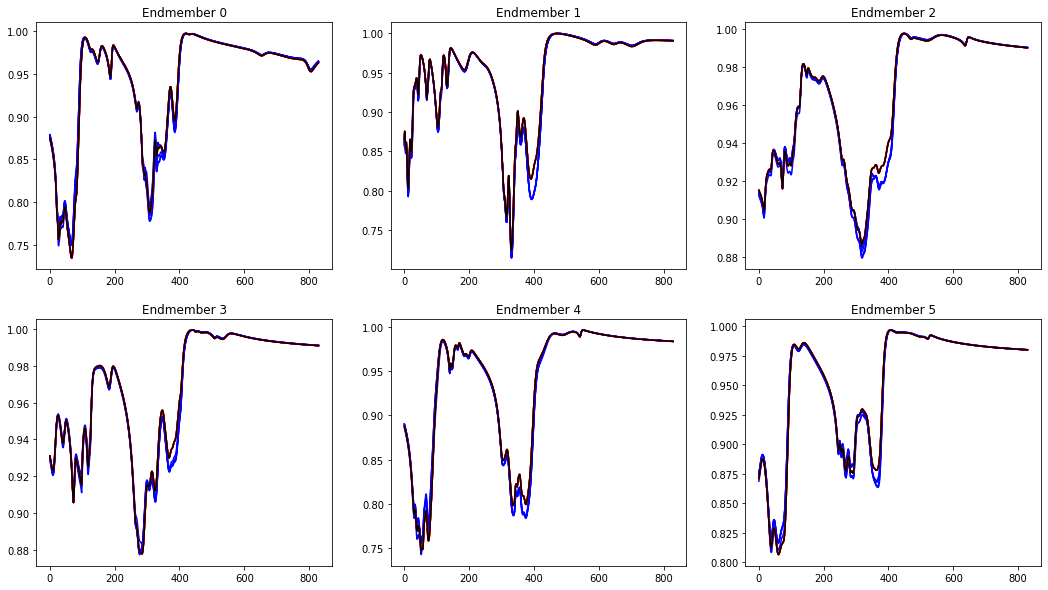

In [68]:
# Visualise difference between the signatures obtained by the two approaches for 6 endmembers
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for em in range(6):
    for i in range(5):
        axs[em//3][em%3].plot(p_sig[i,em,:], color='b')
        axs[em//3][em%3].plot(j_sig[i,em,:], color='r')
    axs[em//3][em%3].plot(m0[i, em, :], color='k')
    axs[em//3][em%3].set_title(f'Endmember {em}')
plt.savefig('data/results_feely/spectral_variab.png')

In [71]:
dot = np.zeros((5, 6))
for i in range(5):
    for p in range(6):
        dot[i,p] = (j_sig[i,p,:] @ p_sig[i,p,:])/(np.linalg.norm(p_sig[i,p,:]) * np.linalg.norm(j_sig[i,p,:]))

In [72]:
# Compute some evaluation metrics
for i in range(6):
    asam = np.sum(np.arccos(dot[:,i]))/(5)
    rmse = np.linalg.norm(j_sig[:,i] - p_sig[:,i])/(5)
    mse = np.sum((j_ab[:,i] - p_ab[:,i])**2)/(5)
    print(f'EM {i}: aSAM = {asam}, RMSE_sig = {rmse}, MSE_ab = {mse}')

EM 0: aSAM = 0.006214508692274691, RMSE_sig = 0.07725367046682247, MSE_ab = 0.009356937469225158
EM 1: aSAM = 0.007203073502557495, RMSE_sig = 0.09448065277280857, MSE_ab = 0.018444702747286122
EM 2: aSAM = 0.002893224582065598, RMSE_sig = 0.03942042490944837, MSE_ab = 0.0018726601326707697
EM 3: aSAM = 0.0027625102365764894, RMSE_sig = 0.0361013132639636, MSE_ab = 5.290735365272495e-05
EM 4: aSAM = 0.006733778659018874, RMSE_sig = 0.08348123688936854, MSE_ab = 6.796633960587136e-05
EM 5: aSAM = 0.004557871881444918, RMSE_sig = 0.05693904374681123, MSE_ab = 4.311081338977679e-05


In [77]:
print("Global aSAM = {},  RMSE_E = {}, MSE_ab = {}".format(np.sum(np.arccos(dot))/(5*6), np.sum((j_sig - p_sig)**2)/(5*38), np.sum((j_ab - p_ab)**2)/(5*38)))

Global aSAM = 0.005060827925656345,  RMSE_E = 0.045063818621126864, MSE_ab = 0.005812936978604009


In [76]:
# Mean reconstruction error among the endmembers
hj = 0
for i in range(5):
    hj += 0.5*float(solvers[i].obj.reconstruction_error())
hj/5

0.9487913477944036